#  Import Lib

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from __future__ import print_function
import logging
import time
import math
import imageio
from tqdm.notebook import tqdm
import shutil
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torch.utils.data
import torch.backends.cudnn as cudnn
import torch.nn.parallel
import torch.nn as nn
import torch
import random
import os
import argparse
%matplotlib inline

# util

In [3]:
def avg_list(input_list, interval):
    result_list = []
    temp_list = []
    counter = 0
    for val in input_list:
        counter += 1
        temp_list.append(val)
        if counter % interval == 0:
            result_list.append(np.mean(temp_list))
            temp_list = []
    return result_list


def sample_list(input_list, interval):
    result_list = []
    counter = 0
    for val in input_list:
        if counter % interval == 0:
            result_list.append(val)
        counter += 1
    return result_list

# read data from file

In [4]:
def read_log_file(filename, interval=99):
    acc1, acc2, acc3 = [], [], []
    datafile = open(filename, 'r')
    data = datafile.readlines()
    for line in data:

        if line.find('BER') == -1:
            continue

        BREs = line.split('|')
        for BRE in BREs:
            if BRE.find('BER') == -1:
                continue
            real_BRE = BRE.strip(' ')
            name, value = real_BRE.split(':')
            if name == 'BER_1':
                acc1.append(value)
            if name == 'BER_2':
                acc2.append(value)
            if name == 'BER_3':
                acc3.append(value)

    # string to float
    acc1 = list(map(float, acc1))
    acc2 = list(map(float, acc2))
    acc3 = list(map(float, acc3))

    # sample data from acc
    sample_acc1 = sample_list(acc1, interval)
    sample_acc2 = sample_list(acc2, interval)
    sample_acc3 = sample_list(acc3, interval)

    return sample_acc1, sample_acc2, sample_acc3

# plot acc cure in 1000 epoch

In [32]:
sample_acc1, sample_acc2, sample_acc3 = read_log_file(
    '../input/log/BackForDcgan_FileNumber_1.txt', interval=100)
# x=np.linspace(0,4,10)
len(sample_acc1), len(sample_acc2), len(sample_acc3)

(30, 30, 30)

<Figure size 400x320 with 0 Axes>

(-1.0, 12.0)

(0.0, 0.5)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 8 Text major ticklabel objects>)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
 <a list of 6 Text major ticklabel objects>)

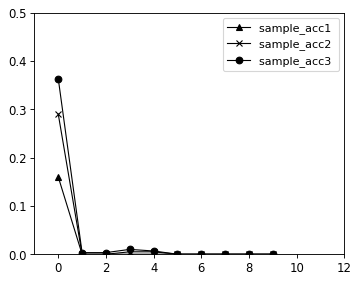

In [34]:
plt.figure(figsize=(5, 4), dpi=80)
plt.subplot(1, 1, 1)
# plt.ylim((0, 1))
# plt.axis([0, 100, 0, 1])
plt.plot(sample_acc1[:10],
         label='sample_acc1 ',
         marker='^',
         color='black',
         linewidth=1)
plt.plot(sample_acc2[:10],
         label='sample_acc2 ',
         marker='x',
         color='black',
         linewidth=1)
plt.plot(sample_acc3[:10],
         label='sample_acc3 ',
         marker='o',
         color='black',
         linewidth=1)
plt.xlim((-1, 12))
plt.ylim((0, 0.5))
plt.xticks(fontsize=10.5)
plt.yticks(fontsize=10.5)
plt.legend()
plt.savefig('./result/plot_acc_cure_in_1000_epoch.jpg')

# find acc epoch in equal to min

In [46]:
def find_epoch_accEQZero(findlist):
    result_list = []
    for i in findlist:
        if i == 0:
            result_list.append(i)
            break
        result_list.append(i)
    return result_list


def reduce_dot(reduce_list, max_dot_num=10, mean=False):
    x_position = []
    resut_list = []
    len_reduce_list = len(reduce_list)
    interval = len(reduce_list) / (max_dot_num)
    #frist elem
    x_position.append(0)
    resut_list.append(reduce_list[0])
    #others elem
    for i in range(1, max_dot_num - 1):
        eqZeroDotPosition_index = int(np.floor(interval * (i)))
        x_position.append(eqZeroDotPosition_index)
        if mean == False:
            resut_list.append(reduce_list[eqZeroDotPosition_index])
        else:
            compute_mean_val = np.mean(
                reduce_list[x_position[-2]:eqZeroDotPosition_index+1])
            resut_list.append(compute_mean_val)
    #last elem
    x_position.append(interval * max_dot_num - 1)
    resut_list.append(reduce_list[len(reduce_list) - 1])
    return x_position, resut_list


In [47]:
sample_acc1, _, _ = read_log_file('../input/log/BackForDcgan_FileNumber_1.txt')
sample_acc2, _, _ = read_log_file(
    '../input/log/BackForDcgan_FileNumber_128.txt')
sample_acc3, _, _ = read_log_file(
    '../input/log/BackForDcgan_FileNumber_1024.txt')
findepoch_sample_acc1 = sample_acc1[:sample_acc1.index(min(sample_acc1)) + 1]
findepoch_sample_acc2 = sample_acc2[:sample_acc2.index(min(sample_acc2)) + 1]
findepoch_sample_acc3 = sample_acc3[:sample_acc3.index(min(sample_acc3)) + 1]
reduce_acc1 = reduce_dot(findepoch_sample_acc1,
                         max_dot_num=len(findepoch_sample_acc1),
                         mean=False)
reduce_acc2 = reduce_dot(findepoch_sample_acc2,
                         max_dot_num=len(findepoch_sample_acc2),
                         mean=False)
reduce_acc3 = reduce_dot(findepoch_sample_acc3,
                         max_dot_num=len(findepoch_sample_acc3),
                         mean=False)

UnboundLocalError: local variable 'compute_mean_val' referenced before assignment

<Figure size 400x320 with 0 Axes>

ValueError: x and y must have same first dimension, but have shapes (10,) and (18,)

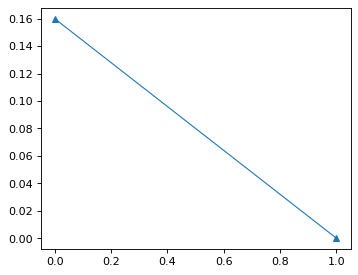

In [45]:
plt.figure(figsize=(5, 4), dpi=80)
plt.subplot(1, 1, 1)
# plt.ylim((0, 1))
# plt.axis([0, 100, 0, 1])
plt.plot(reduce_acc1[0],
         reduce_acc1[1],
#          color='black',
         label='sample_acc1 ',
         marker='^',
         linewidth=1)
plt.plot(reduce_acc2[0],
         reduce_acc2[1],
#          color='black',
         label='sample_acc2 ',
         marker='x',
         linewidth=1)
# plt.plot(reduce_acc3[0],
#          reduce_acc3[1],
# #          color='black',
#          label='sample_acc3 ',
#          marker='o',
#          linewidth=1)
plt.xlim((-1, 12))
# plt.ylim((0, 0.5))
plt.xticks(fontsize=10.5)
plt.yticks(fontsize=10.5)
plt.legend()
plt.savefig('./result/find_acc_epoch_in_equal_to_0.jpg')

# plot extract net of acc

In [35]:
sample_acc1, sample_acc2, sample_acc3 = read_log_file(
    '../input/log/ExtractNet.log', interval=100)
sample_acc1 = sample_acc1[:int(len(sample_acc1) // 2)]
sample_acc2 = sample_acc2[:int(len(sample_acc2) // 2)]
sample_acc3 = sample_acc3[:int(len(sample_acc3) // 2)]
len(sample_acc1), len(sample_acc2), len(sample_acc3)

(13, 13, 13)

<Figure size 400x320 with 0 Axes>

(-1.0, 12.0)

(0.0, 0.5)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 8 Text major ticklabel objects>)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
 <a list of 6 Text major ticklabel objects>)

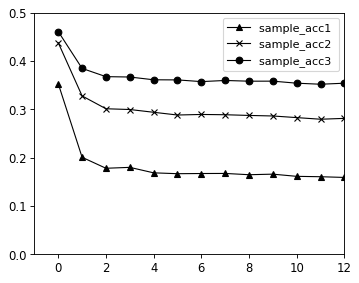

In [36]:
plt.figure(figsize=(5, 4), dpi=80)
plt.subplot(1, 1, 1)
# plt.ylim((0, 1))
# plt.axis([0, 100, 0, 1])
plt.plot(sample_acc1,
         label='sample_acc1 ',
         marker='^',
         color='black',
         linewidth=1)
plt.plot(sample_acc2,
         label='sample_acc2 ',
         marker='x',
         color='black',
         linewidth=1)
plt.plot(sample_acc3,
         label='sample_acc3 ',
         marker='o',
         color='black',
         linewidth=1)
plt.xlim((-1,12))
plt.ylim((0, 0.5))
plt.xticks(fontsize=10.5)
plt.yticks(fontsize=10.5)
plt.legend()
plt.savefig('./result/extractNet.jpg')